<a href="https://colab.research.google.com/github/DLaux/BSA2020_Team_Tissot_Project_2/blob/master/Notebook_Tissot_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pandas -q

In [0]:
import pandas as pd


In [0]:

df_train = pd.read_csv("https://raw.githubusercontent.com/DLaux/BSA2020_Team_Tissot_Project_2/master/data/train.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)

In [0]:
df_test = pd.read_csv("https://raw.githubusercontent.com/DLaux/BSA2020_Team_Tissot_Project_2/master/data/test.csv", 
                          encoding='utf_8', 
                          dtype = 'unicode',
                          parse_dates = True,
                          infer_datetime_format = True,
                          low_memory=False)

In [5]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


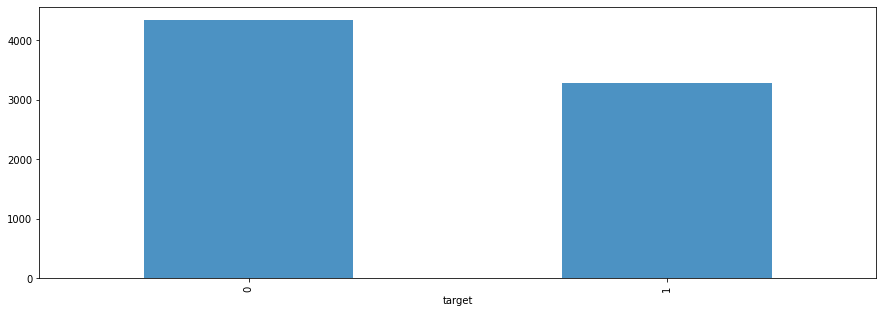

In [6]:
r1 = df_train[["id","target"]].groupby(["target"]).count()
r1.plot.bar(x=None, 
            y=None,
            figsize=(15,5), 
            alpha = 0.8, # make the plot 20% transparent
            legend = None, 
           )

In [7]:
print("The most common class for the target is", df_train["target"].mode()[0])

baseRate = df_train[df_train["target"] == df_train["target"].mode()[0]].count()["target"] / df_train["target"].count()
print("The baserate is :", baseRate)

The most common class for the target is 0
The baserate is : 0.5703402075397347


## **Preprocess data**

In [0]:
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from pprint import pprint
from time import time

In [0]:
X = df_train
X = X.drop(["target", "id"], axis = 1)
y = df_train["target"]

In [0]:
#encode the target 
lab_enc = preprocessing.LabelEncoder()
encoded_y = lab_enc.fit_transform(y)

In [0]:
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.2, random_state=72)

We will split the train data at first to figure out the best models and parameters. For the final submissions we will retrain de the best model with the full train set.

### Text preprocessing
Remove some characters and punctuation.

source: 
https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.text)
X_train_counts.shape

(6090, 18519)

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(6090, 18519)

In [0]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [0]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])

text_clf = text_clf.fit(X_train.text, y_train)

In [16]:
import numpy as np
predicted = text_clf.predict(X_test.text)
np.mean(predicted == y_test)

0.7898883782009193

In [0]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge',max_iter=100, penalty='l2',alpha=1e-3, random_state=42)),])
text_clf_svm = text_clf_svm.fit(X_train.text, y_train)


In [27]:

predicted_svm = text_clf_svm.predict(X_test.text)
np.mean(predicted_svm == y_test)

0.7734734077478661

Let's try some gridseatch to optimize the parameters


In [0]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
              }

In [0]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train.text, y_train)

In [31]:
gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

In [0]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

## **Random Forest Classifier**

In [0]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
MAE = make_scorer(mean_absolute_error)
folds = 3

In [0]:
clf = RandomForestClassifier(n_estimators = 200,max_depth = 30)
clf.fit(X_train, y_train)

ValueError: ignored